In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from pprint import pprint

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

import random
import string
import seaborn as sns
import os
import numpy as np
import timeit

In [2]:
model_logs_root = '/Users/rohan/Documents/python-projects/deepracer/2022-October/Logs-SteerSpeedDist-Diff-8Hours'
log = DeepRacerLog(model_logs_root)

# load logs into a dataframe
log.load()

try:
    pprint(log.agent_and_network())
    print("-------------")
    pprint(log.hyperparameters())
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Robomaker logs not available")

df = log.dataframe()

{'network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'sensor_list': ['FRONT_FACING_CAMERA'],
 'simapp_version': '4'}
-------------
{'batch_size': 64,
 'beta_entropy': 0.01,
 'discount_factor': 0.999,
 'e_greedy_value': 0.05,
 'epsilon_steps': 10000,
 'exploration_type': 'categorical',
 'loss_type': 'huber',
 'lr': 0.0003,
 'num_episodes_between_training': 20,
 'num_epochs': 10,
 'stack_size': 1,
 'term_cond_avg_score': 350000000.0,
 'term_cond_max_episodes': 1000000000}
-------------
{'speed': {'high': 1.0, 'low': 0.5},
 'steering_angle': {'high': 30.0, 'low': -30.0}}


In [3]:
track_path = "/Users/rohan/Documents/python-projects/deepracer/deepracer-k1999-race-lines/tracks/"
ListFiles = [f for f in os.listdir(track_path) if os.path.isfile(os.path.join(track_path, f))]
print(ListFiles)

['reInvent2019_track.npy', '2022_august_open.npy', 'Canada_Training.npy', 'canada_race.npy', 'Tokyo_Training_track.npy', 'Oval_track.npy', 'New_York_Track.npy', 'Bowtie_track.npy', 'H_track.npy', 'reinvent_base.npy', '2022_september_open.npy', 'Mexico_track.npy', 'Virtual_May19_Train_track.npy', 'Straight_track.npy', 'AWS_track.npy', 'China_track.npy', '2022_july_open.npy', '2022_june_open.npy', 'London_Loop_Train.npy']


In [4]:
def get_track_waypoints(track_name):
    return np.load("%s/%s.npy" % (track_path, track_name))

trackname="2022_september_open"
waypoints = get_track_waypoints(trackname)
waypoints.shape

(152, 6)

In [5]:
center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

In [6]:
def plot_track(ax):
    ax.plot(inner_border[:, 0], inner_border[:, 1], '.', color='#646464', zorder=1)
    ax.plot(outer_border[:, 0], outer_border[:, 1], '.', color='#646464', zorder=1)
    ax.plot(inner_border[:, 0], inner_border[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    ax.plot(outer_border[:, 0], outer_border[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

In [7]:
from numpy import array

fname = '../deepracer-k1999-race-lines/racelines/2022_september_open-2000-4-2022-10-23-145109.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
racing_line = deserialized
racing_line.shape

(152, 2)

In [8]:
def plot_racing_line(ax, zdot=1, zline=2):
    ax.plot(racing_line[:, 0], racing_line[:, 1], '.', color='#646464', zorder=zdot)
    ax.plot(racing_line[:, 0], racing_line[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=zline)

In [9]:
npoints = len(racing_line) - 1

In [10]:
coords_start = df[df['steps'] == 1][['x', 'y']].to_numpy()
coords_start = np.unique(np.round(coords_start, 1), axis=0)

coords_desmos = np.array_repr(coords_start)
coords_desmos = coords_desmos[7:-2]
coords_desmos = coords_desmos.replace("       ", "")
coords_desmos = coords_desmos.replace("[", "(")
coords_desmos = coords_desmos.replace("],", ")")
coords_desmos = coords_desmos.replace("]", ")")

if coords_start.shape[0] != 20:
    print("Please remove duplicates from round robin starting coordinates\n")
else:
    print("Round robin starting coordinates look good\n")

table_data_code = [
    '\tstate = Calc.getState()',
    '\texprs = state.expressions.list',
    '\tout = "[\\n"',
    '\tfor (let i = 0; i < exprs.length; i++) {',
    '\t    if (exprs[i].type != "table") {',
    '\t    continue',
    '\t    }',
    '\t    cols = exprs[i].columns',
    '\t    for (let j = 0; j < cols[0].values.length; j++) {',
    '\t        out += "    ["',
    '\t        for (let k = 0; k < cols.length; k++) {',
    '\t            out += cols[k].values[j]',
    '\t            if (k < cols.length - 1) out += ", "',
    '\t        }',
    '\t        out += "],\\n"',
    '\t    }',
    '\t}',
    '\tout += "]"',
    '\tconsole.log(out)',
]

print("Please follow the directions below:")
print("1. Paste the coordinates below into desmos")
print("2. Rearrange the points into the correct order around the track")
print("3. Input the coordinates, in the same order, into a desmos table with two columns: x and y")
print("4. Open the javascript console: Ctrl+Shift+I or right-click inspect then select the console tab")
print("5. Paste the following code into the console to get the data from your table")
print("   Source: https://www.reddit.com/r/desmos/comments/dfnpe2/comment/i94b5gj/?utm_source=share&utm_medium=web2x&context=3")
print("\n".join(table_data_code))
print("6. Copy the data and paste it into the np.array() declaration for coords_order\n")
print(coords_desmos)

Round robin starting coordinates look good

Please follow the directions below:
1. Paste the coordinates below into desmos
2. Rearrange the points into the correct order around the track
3. Input the coordinates, in the same order, into a desmos table with two columns: x and y
4. Open the javascript console: Ctrl+Shift+I or right-click inspect then select the console tab
5. Paste the following code into the console to get the data from your table
   Source: https://www.reddit.com/r/desmos/comments/dfnpe2/comment/i94b5gj/?utm_source=share&utm_medium=web2x&context=3
	state = Calc.getState()
	exprs = state.expressions.list
	out = "[\n"
	for (let i = 0; i < exprs.length; i++) {
	    if (exprs[i].type != "table") {
	    continue
	    }
	    cols = exprs[i].columns
	    for (let j = 0; j < cols[0].values.length; j++) {
	        out += "    ["
	        for (let k = 0; k < cols.length; k++) {
	            out += cols[k].values[j]
	            if (k < cols.length - 1) out += ", "
	        }
	  

In [11]:
coords_order = np.array([
    [6, 1.6],
    [3.8, 2.3],
    [1.6, 2.9],
    [-0.4, 3.9],
    [-2.4, 5],
    [-4.4, 6],
    [-6.3, 6],
    [-7.5, 4.1],
    [-6.9, 2.1],
    [-5, 0.9],
    [-5.2, -1],
    [-6.1, -3],
    [-4.3, -4.3],
    [-2.3, -5.4],
    [-0.3, -6.5],
    [1.7, -5.8],
    [3.7, -4.6],
    [5.6, -3.5],
    [7, -1.7],
    [7.6, 0.5],
])
start_progresses = np.arange(0, 100, 5)

In [12]:
df = df.rename(columns={'progress': 'old_progress'})
df['progress'] = 0.0
df.head()

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,...,old_progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode,progress
0,0,1.0,5.982886,1.640088,164.126304,1.084680,0.658389,-1,0.000000,False,...,0.309405,0,45.297382,33.958,prepare,0.0,0,0,0,0.0
1,0,2.0,5.982810,1.640114,164.125689,-30.000000,0.725934,-1,0.000000,False,...,0.309581,0,45.297382,34.002,in_progress,0.0,0,0,0,0.0
2,0,3.0,5.958771,1.649860,163.381729,17.440695,0.900887,-1,1.170173,False,...,0.366511,1,45.297382,34.082,in_progress,0.0,0,0,0,0.0
3,0,4.0,5.913971,1.666923,162.475818,-12.290795,0.657645,-1,2.011821,False,...,0.471945,1,45.297382,34.177,in_progress,0.0,0,0,0,0.0
4,0,5.0,5.889224,1.675433,162.273280,6.036035,0.717727,-1,1.201140,False,...,0.529635,1,45.297382,34.217,in_progress,0.0,0,0,0,0.0


In [13]:
start_coords = np.round(df[(df['episode'] == 4) & (df['steps'] == 1)][['x', 'y']].to_numpy(), 1)[0]
(np.sum(np.abs(coords_order - start_coords), axis=1) == 0).nonzero()[0][0]

4

In [14]:
for ep in df['episode'].unique():
    cur = df.index[df['episode'] == ep]
    start_coords = np.round(df[(df['episode'] == ep) & (df['steps'] == 1)][['x', 'y']].to_numpy(), 1)[0]
    idx = (np.sum(np.abs(coords_order - start_coords), axis=1) == 0).nonzero()[0][0]
    start_progress = start_progresses[idx]
    for i in range(len(cur)):
        df.at[cur[i], 'progress'] = (df.at[cur[i], 'old_progress'] + start_progress) % 100

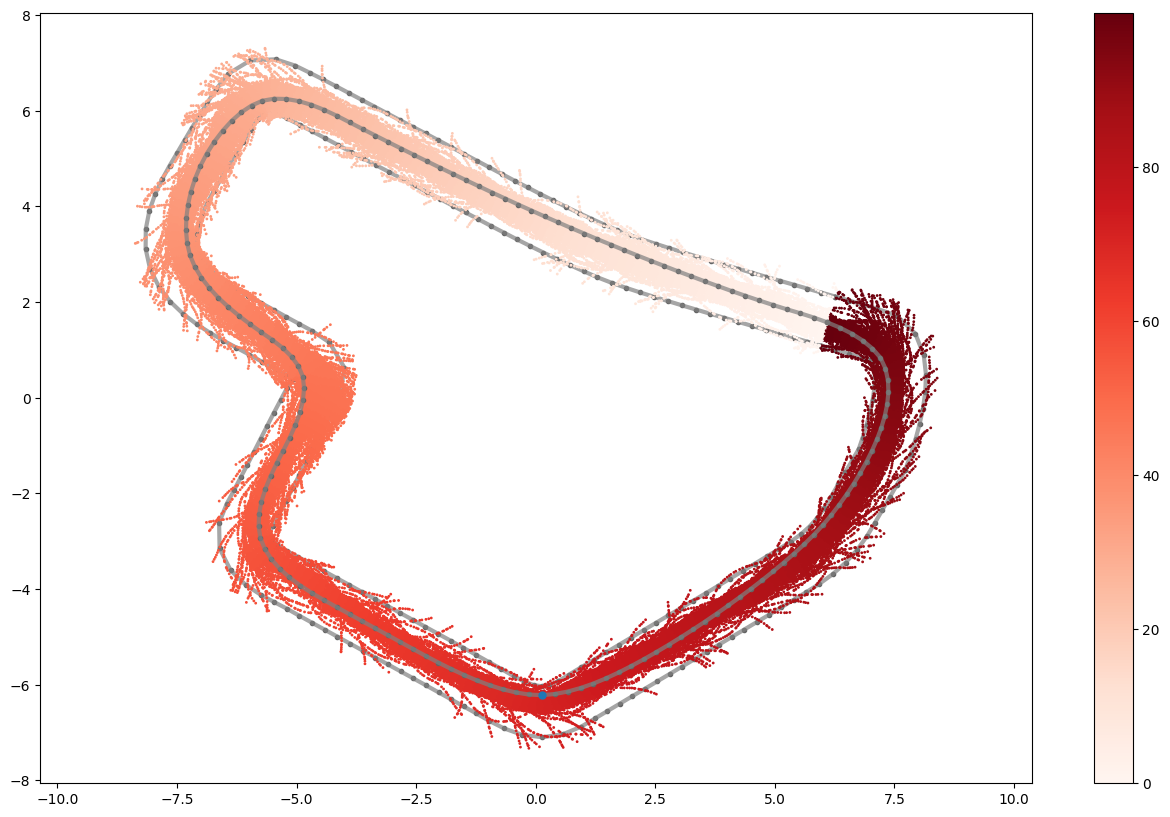

In [15]:
fig = plt.figure(2, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax)
scatter = ax.scatter(
    df['x'], df['y'], s=1,
    c=df['progress'], cmap='Reds', zorder=3
)
plot_racing_line(ax, 4, 5)
ax.plot(racing_line[107, 0], racing_line[107, 1], marker="o", markersize=5, zorder=6)
fig.colorbar(scatter)

In [16]:
waypoint_progress = np.zeros(npoints)

for i in range(npoints):
    dist = np.hypot(racing_line[i, 0] - df['x'], racing_line[i, 1] - df['y'])
    waypoint_progress[i] = df.iloc[dist.idxmin()]['progress']

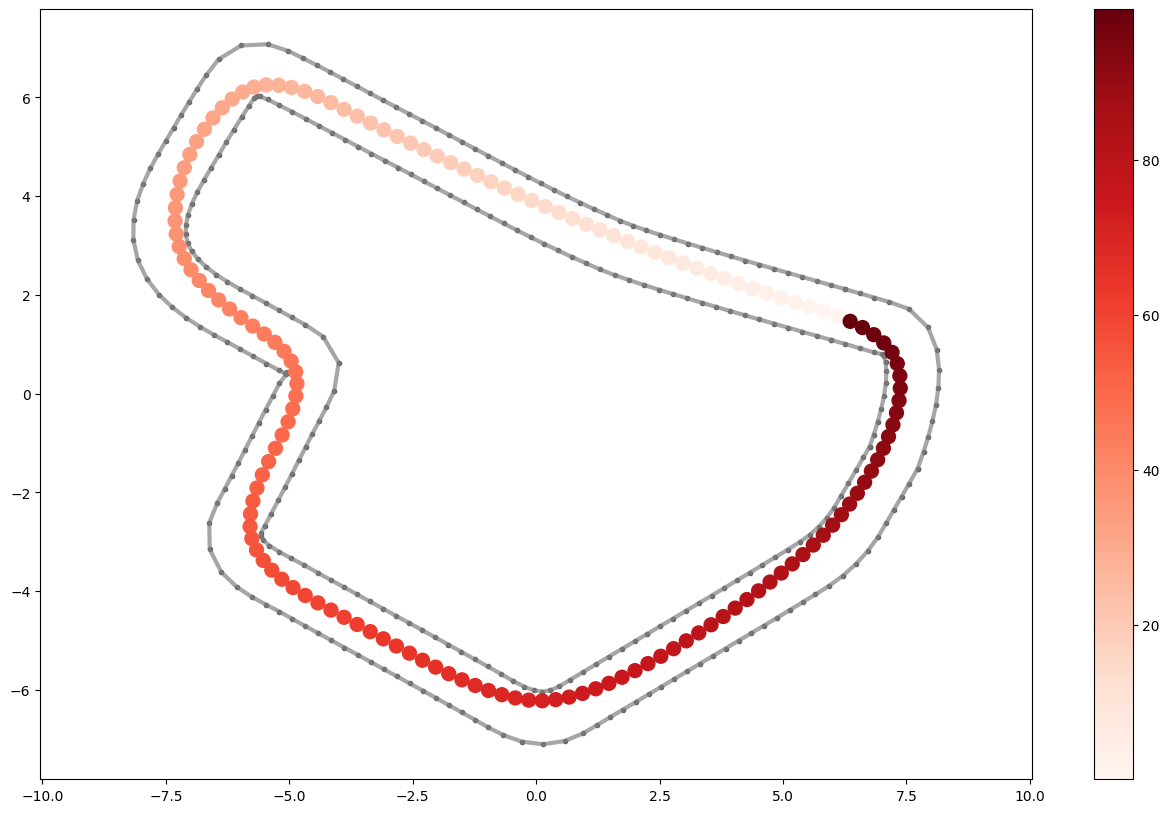

In [17]:
fig = plt.figure(2, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax)
scatter = ax.scatter(
    racing_line[:npoints, 0], racing_line[:npoints, 1], s=100,
    c=waypoint_progress, cmap='Reds', zorder=3
)
fig.colorbar(scatter)

In [56]:
STEPS_PER_WAYPOINT = 5.47
step_diff = ((np.roll(waypoint_progress, -1) - waypoint_progress) % 100) / STEPS_PER_WAYPOINT
step_diff.mean()

0.12106977250989746

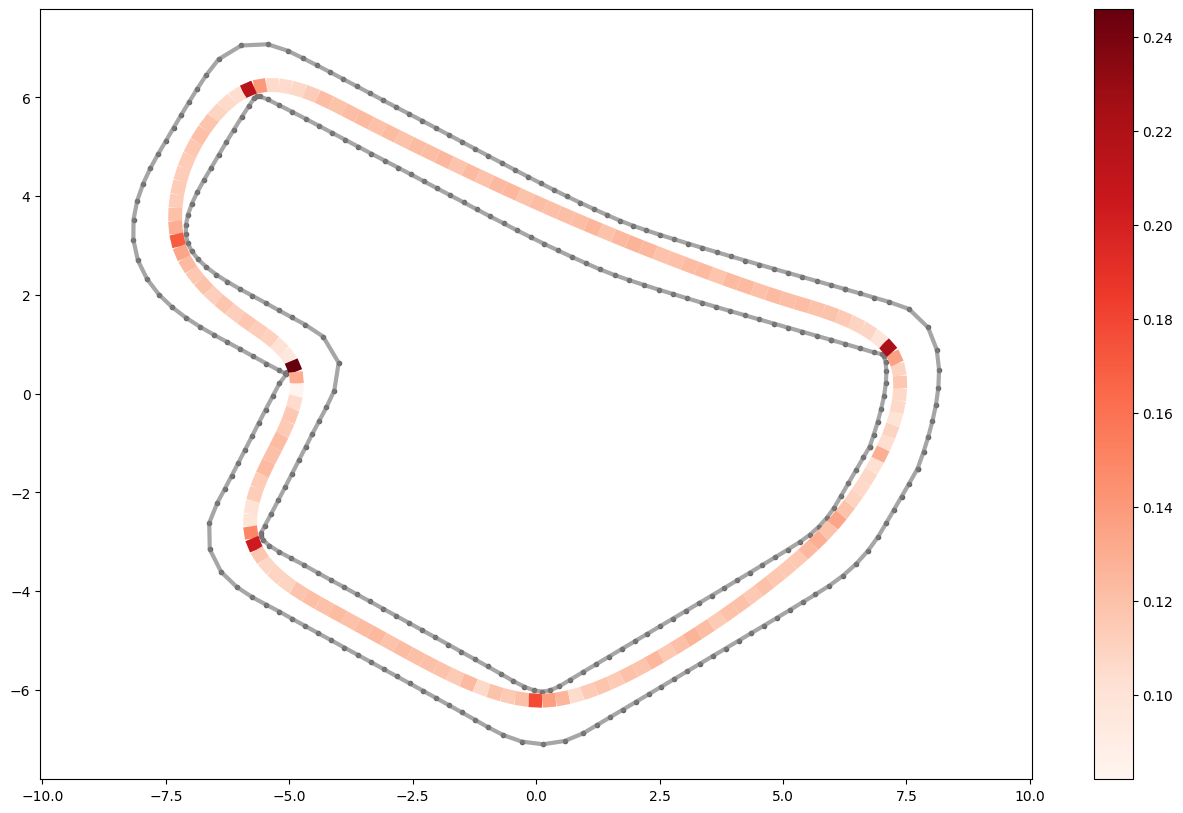

In [57]:
fig = plt.figure(2, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax)
segments = np.hstack((racing_line[:npoints, np.newaxis], np.roll(racing_line[:npoints], -1, axis=0)[:, np.newaxis]))
lc = LineCollection(segments, linewidths=10, cmap='Reds')
lc.set_array(step_diff)
ax.add_collection(lc)
fig.colorbar(lc)

In [58]:
#average distance between racing line waypoints
np.sum(np.hypot(segments[:, 0, 0] - segments[:, 1, 0], segments[:, 0, 1] - segments[:, 1, 1])) / segments.shape[0]

0.2837633132726763

In [59]:
#average distance between deepracer steps
distance_sum = 0
distance_num = 0
for ep in df['episode'].unique():
    coords = df[df['episode'] == ep][['x', 'y']].to_numpy()
    distance_sum += np.sum(np.hypot(coords[1:, 0] - coords[:-1, 0], coords[1:, 1] - coords[:-1, 1]))
    distance_num += len(coords) - 1

distance_sum / distance_num

0.05182031904264901

In [60]:
0.2837633132726763 / STEPS_PER_WAYPOINT


0.051876291274712306

In [61]:
custom_df = df
segments = np.empty((len(custom_df) - len(custom_df['episode'].unique()), 2, 2))
diff = np.empty((len(custom_df) - len(custom_df['episode'].unique())))
idx = 0

for ep in custom_df['episode'].unique():
    data = custom_df[custom_df['episode'] == ep][['x', 'y', 'progress']].to_numpy()

    segments[idx:idx + len(data) - 1, 0, :] = data[:-1, :2]
    segments[idx:idx + len(data) - 1, 1, :] = data[1:, :2]
    diff[idx:idx + len(data) - 1] = ((data[1:, 2] - data[:-1, 2] + 50) % 100) - 50

    idx += len(data) - 1

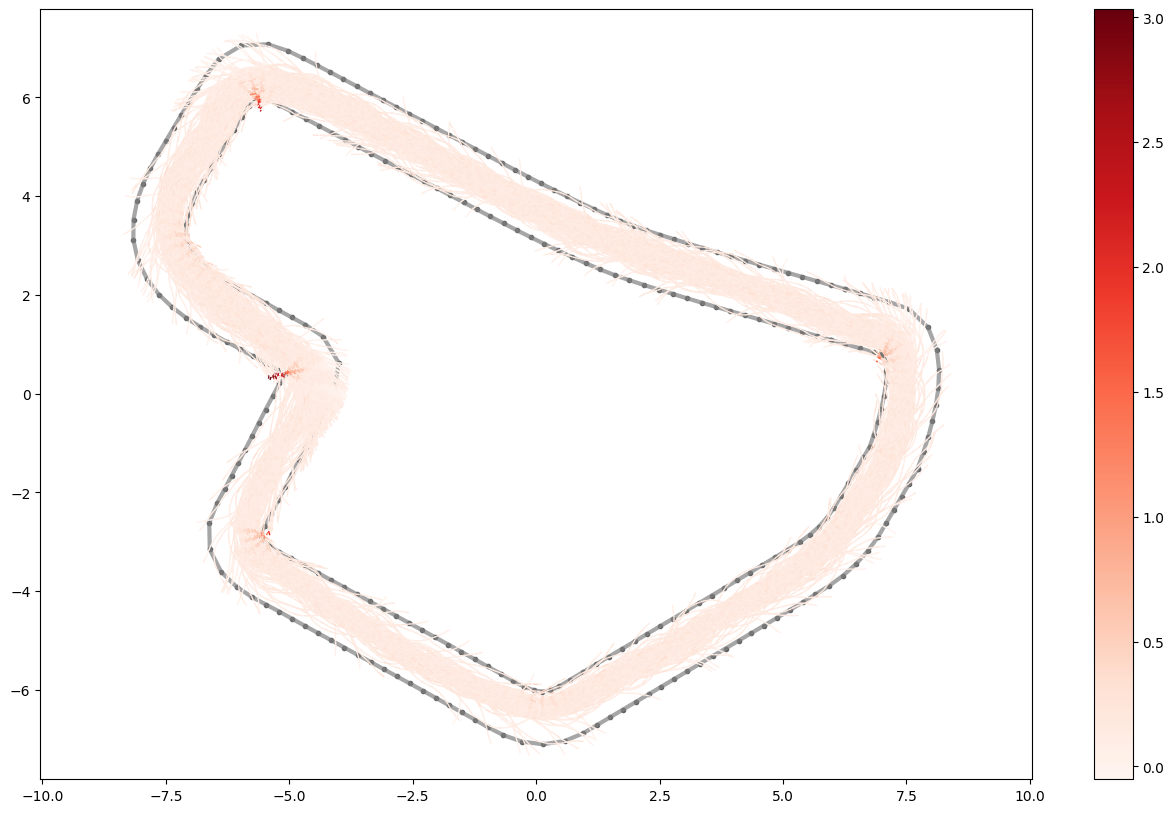

In [62]:
fig = plt.figure(2, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax)
lc = LineCollection(segments, linewidths=1, cmap='Reds')
lc.set_array(diff)
ax.add_collection(lc)
fig.colorbar(lc)

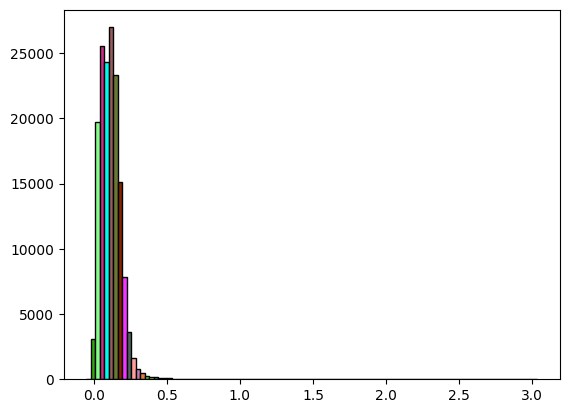

['#8A8D00', '#31A613', '#86FB8B', '#CB2C84', '#02F9ED', '#985C5B', '#687733', '#852402', '#F036FF', '#4D675E', '#FDA09B', '#C67AB7', '#DE7D42', '#39E337', '#BDF427', '#38A988', '#0777B7', '#91B5F5', '#EE1D71', '#DC7F8F', '#EFB790', '#9C20B8', '#9E839E', '#0C3387', '#E65A15', '#5BA807', '#1818F5', '#BBFB9C', '#5F9723', '#188168', '#41B0CC', '#8E1DD1', '#9F1CDE', '#16892B', '#FF7110', '#15E235', '#F5C2F1', '#4A6059', '#573D2B', '#C7AD2E', '#9ADD02', '#31DFE8', '#1DDECA', '#653028', '#E159C4', '#131546', '#83A4B6', '#E694D2', '#FB3B2A', '#731030', '#0CC543', '#E1306A', '#A79F5B', '#D5B626', '#C2F5A2', '#6F2070', '#822716', '#3B8F41', '#466F54', '#81B889', '#511537', '#7FC95E', '#D33561', '#86DF60', '#D774B1', '#2F83B5', '#74F96C', '#BF93A4', '#5F96CE', '#24160F', '#98320E', '#BE5253', '#AEB820', '#BD6300', '#926025', '#3A7988', '#7C606D', '#F8C822', '#63F916', '#D3A1D7', '#F52E00', '#14D35F', '#00B1F4', '#0B51D2', '#72175D', '#301C2D', '#400F5D', '#6D6F9D', '#7D7476', '#878C61', '#E8BAF4'

In [49]:
import random
import string

# Figure and set of subplots
fig, ax = plt.subplots()

# Plot a histogram with random data
N, bins, patches = ax.hist(diff, bins=100, edgecolor='black', linewidth=1)

# Random facecolor for each bar
colors = []
for i in range(len(N)):
    colors.append("#" + ''.join(random.choices("ABCDEF" + string.digits, k=6)))
    patches[i].set_facecolor(colors[i])

# Display the plot
plt.show()
print(colors)
print(bins)

In [52]:
diff[diff < 0.3].mean()

0.10880914648556954

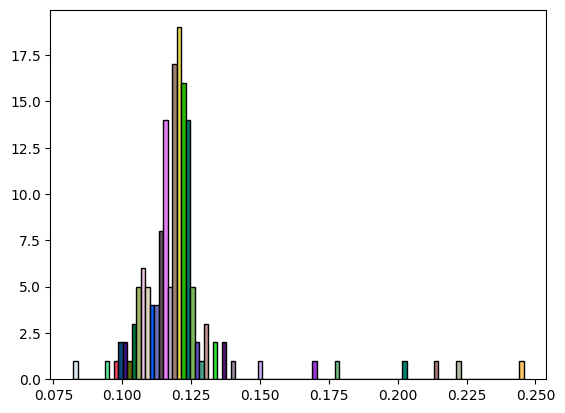

['#D6E6E9', '#47C083', '#9B3390', '#38F516', '#2049FC', '#0BF412', '#29B802', '#58EA99', '#08DE88', '#F44463', '#0A487C', '#381478', '#5D6807', '#007437', '#9EB664', '#E5C2DF', '#DDD3BC', '#025DFF', '#6B6FB3', '#624F59', '#E47EF7', '#C7B2D0', '#9F7E72', '#E6D553', '#2AB801', '#017569', '#7DB659', '#5E4DC0', '#49A28C', '#BF9691', '#D5DA02', '#2AE82E', '#281C97', '#4A1B66', '#907613', '#978699', '#30D247', '#CF7392', '#606D41', '#FC5394', '#E3CD89', '#CCAEF9', '#2172DE', '#3F920E', '#180103', '#E95D5C', '#ED6754', '#081463', '#DD2208', '#22E5A3', '#7F889A', '#0F4BE4', '#E4AB93', '#9537D0', '#86F62A', '#665477', '#613B59', '#FC814B', '#73BD86', '#B67BBC', '#7A25AD', '#8BB3C4', '#AF7B36', '#5842FE', '#36A612', '#2E9BBB', '#0F3C45', '#2941AE', '#87B0A2', '#77A532', '#780605', '#497CBE', '#42F7DC', '#067F6B', '#E27BDF', '#579053', '#FB1CDB', '#9C5529', '#BF3F46', '#3427AC', '#A97C77', '#46E557', '#219A76', '#C8B0B4', '#D6099B', '#B0BAA5', '#60348D', '#587C2D', '#06CC5E', '#B3EF5D', '#842ED1'

In [43]:
import random
import string

# Figure and set of subplots
fig, ax = plt.subplots()

# Plot a histogram with random data
N, bins, patches = ax.hist(step_diff, bins=100, edgecolor='black', linewidth=1)

# Random facecolor for each bar
colors = []
for i in range(len(N)):
    colors.append("#" + ''.join(random.choices("ABCDEF" + string.digits, k=6)))
    patches[i].set_facecolor(colors[i])

# Display the plot
plt.show()
print(colors)
print(bins)

In [53]:
step_diff[step_diff < 0.15].mean()

0.11757573155811475

In [64]:
step_diff.size

151